# Importing Necessary libraries

In [8]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
import os 
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image
import shutil
from shutil import copyfile
from sklearn.model_selection import train_test_split
from tqdm import tqdm


# Loading Dataset

In [9]:
shutil.rmtree('/kaggle/working/breast-histopathology-images')

In [10]:
try:
    os.mkdir('/kaggle/working/breast-histopathology-images')
    os.mkdir('/kaggle/working/breast-histopathology-images/training')
    os.mkdir('/kaggle/working/breast-histopathology-images/validation')
    os.mkdir('/kaggle/working/breast-histopathology-images/test')
    os.mkdir('/kaggle/working/breast-histopathology-images/training/negative')
    os.mkdir('/kaggle/working/breast-histopathology-images/training/positive')
    os.mkdir('/kaggle/working/breast-histopathology-images/validation/negative')
    os.mkdir('/kaggle/working/breast-histopathology-images/validation/positive')
    os.mkdir('/kaggle/working/breast-histopathology-images/test/negative')
    os.mkdir('/kaggle/working/breast-histopathology-images/test/positive')
except OSError:
    print('Error failed to make directory')

In [11]:
file_img_neg = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/*/0/*.png')
file_img_pos = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/*/1/*.png')

In [12]:
print(len(file_img_neg), len(file_img_pos))

198738 78786


In [13]:
train_img_neg, val_img_neg = train_test_split(file_img_neg[:12389], test_size=0.2, random_state=42)
train_img_pos, val_img_pos = train_test_split(file_img_pos[:12389], test_size=0.2, random_state=42)

In [14]:
for img_path in tqdm(train_img_neg):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/training/negative/{filename}')

for img_path in tqdm(train_img_pos):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/training/positive/{filename}')

for img_path in tqdm(val_img_neg):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/validation/negative/{filename}')

for img_path in tqdm(val_img_pos):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/validation/positive/{filename}')


100%|██████████| 2478/2478 [00:17<00:00, 141.51it/s]


# Data Preprocessing

In [63]:
from skimage import io
from skimage.color import rgb2hed, hed2rgb

def stain_normalization(image):
    """
    Apply stain normalization to an image using the Reinhard method.
    """
    # Convert the image to HED color space
    ihc_hed = rgb2hed(image)
    
    # Define target mean and standard deviations for HED channels
    target_hed_mean = np.array([0.18, 0.18, 0.18])
    target_hed_std = np.array([0.1, 0.1, 0.1])
    
    # Calculate the means and standard deviations of the HED channels
    hed_mean = np.mean(ihc_hed, axis=(0, 1))
    hed_std = np.std(ihc_hed, axis=(0, 1))
    
    # Perform stain normalization
    ihc_hed_normalized = (ihc_hed - hed_mean) / hed_std * target_hed_std + target_hed_mean
    
    # Convert the normalized image back to RGB color space
    normalized_image = hed2rgb(ihc_hed_normalized)
    
    return normalized_image

# Modeling

In [16]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [58]:
train_datagen = ImageDataGenerator(
#     preprocessing_function=stain_normalization,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(
#     preprocessing_function=stain_normalization,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [59]:
train_data_dir = '/kaggle/working/breast-histopathology-images/training'
valid_data_dir = '/kaggle/working/breast-histopathology-images/validation'
train_set = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(50, 50),
    batch_size=32,
    color_mode="rgb",
    shuffle=True,
    class_mode='binary'
)

val_set = val_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(50, 50),
    batch_size=32,
    color_mode="rgb",
    shuffle=True,
    class_mode='binary')

Found 19822 images belonging to 2 classes.
Found 4956 images belonging to 2 classes.


In [29]:
test_neg = file_img_neg[12389:13389]
test_pos = file_img_pos[12389:13389]

for img_path in tqdm(test_neg):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/test/negative/{filename}')

for img_path in tqdm(test_pos):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/test/positive/{filename}')

100%|██████████| 1000/1000 [00:07<00:00, 130.96it/s]


In [86]:
test_datagen = ImageDataGenerator(
)
test_dir  = '/kaggle/working/breast-histopathology-images/validation'
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50,50),
    batch_size=1,
    shuffle=False,
    class_mode='binary',
    color_mode='rgb'
)

Found 4956 images belonging to 2 classes.


# train model efficientnet b0

In [19]:
!pip install -U efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00


In [65]:
from keras.layers import Dense
from keras.optimizers import Adam
from keras.applications import EfficientNetB3  # Import EfficientNetB0

efficient_net = EfficientNetB3(
    weights='imagenet',
    input_shape=(50, 50, 3),  # Adjust input shape to (50, 50, 3)
    include_top=False,
    pooling='max'
)

model_b3 = Sequential()
model_b3.add(efficient_net)
model_b3.add(BatchNormalization())
model_b3.add(Dense(120, activation='relu'))
model_b3.add(BatchNormalization())
model_b3.add(Dense(120, activation='relu'))
model_b3.add(Dense(1, activation='sigmoid'))
model_b3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_6 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 120)               184440    
                                                                 
 batch_normalization_7 (Batc  (None, 120)              480       
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 120)               14520     
                                                                 
 dense_14 (Dense)            (None, 1)                

In [66]:
model_b3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [67]:
history_b3 = model_b3.fit_generator(
    train_set,
    epochs = 20,
    validation_data = val_set,
    verbose=True
)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """
2024-04-27 16:40:23.790895: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


620/620 [==============================] - 60s 71ms/step - loss: 0.4882 - accuracy: 0.7701 - val_loss: 0.3868 - val_accuracy: 0.8331
Epoch 2/20
620/620 [==============================] - 41s 66ms/step - loss: 0.3821 - accuracy: 0.8350 - val_loss: 0.3452 - val_accuracy: 0.8569
Epoch 3/20
620/620 [==============================] - 41s 66ms/step - loss: 0.3383 - accuracy: 0.8577 - val_loss: 0.3121 - val_accuracy: 0.8678
Epoch 4/20
620/620 [==============================] - 40s 65ms/step - loss: 0.3110 - accuracy: 0.8687 - val_loss: 0.2942 - val_accuracy: 0.8771
Epoch 5/20
620/620 [==============================] - 40s 65ms/step - loss: 0.2918 - accuracy: 0.8795 - val_loss: 0.2844 - val_accuracy: 0.8858
Epoch 6/20
620/620 [==============================] - 40s 65ms/step - loss: 0.2690 - accuracy: 0.8903 - val_loss: 0.2756 - val_accuracy: 0.8838
Epoch 7/20
620/620 [==============================] - 41s 65ms/step - loss: 0.2485 - accuracy: 0.8976 - val_loss: 0.2606 - val_accuracy: 0.8941
Epo

# evaluation

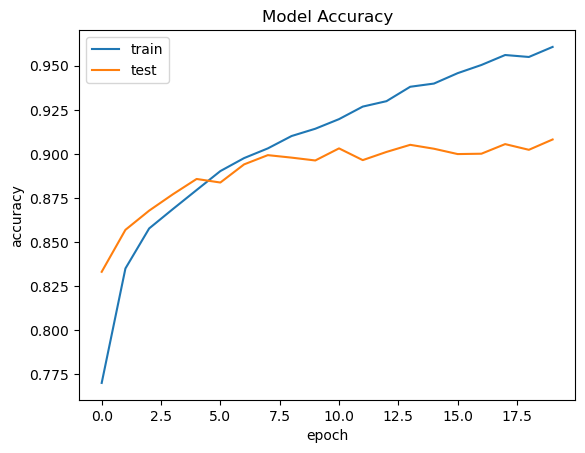

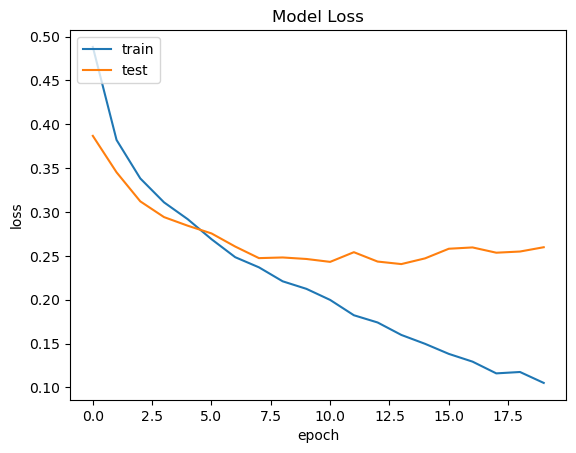

In [102]:
plt.plot(history_b3.history['accuracy'])
plt.plot(history_b3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_b3.history['loss'])
plt.plot(history_b3.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [87]:
preds_b3 = model_b3.predict_generator(
    test_generator,
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [88]:
image_ids = [name.split('/')[-1] for name in test_generator.filenames]
predictions = preds_b3.flatten()
data = {'id': image_ids, 'cancer':predictions} 
submission = pd.DataFrame(data)
submission.head()

,id,cancer
0,10274_idx5_x1001_y1251_class0.png,0.000137
1,10274_idx5_x1001_y2001_class0.png,0.002261
2,10274_idx5_x1001_y551_class0.png,0.048771
3,10274_idx5_x1001_y901_class0.png,0.356362
4,10274_idx5_x101_y1101_class0.png,0.002463


In [89]:
submission['predict'] = submission['cancer'].apply(lambda x: 0 if x < 0.5 else 1)
submission['true'] = submission['id'].apply(lambda x: 0 if 'class0' in x else 1)

accuracy == 0.906


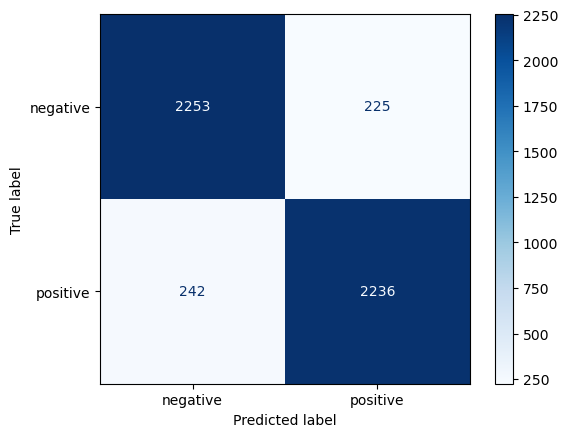

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(submission['true'], submission['predict'])

# Step 4: Display the confusion matrix
labels = test_generator.class_indices.keys()  # Get class labels
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap='Blues')  # plot the confusion matrix
print(f'accuracy == {round(sum(submission.predict == submission.true)/len(submission),3)}')

In [95]:
from sklearn.metrics import roc_curve, auc,classification_report

fpr_keras, tpr_keras, thresholds_keras = roc_curve(submission['true'], submission['predict'])
auc_keras = auc(fpr_keras, tpr_keras)

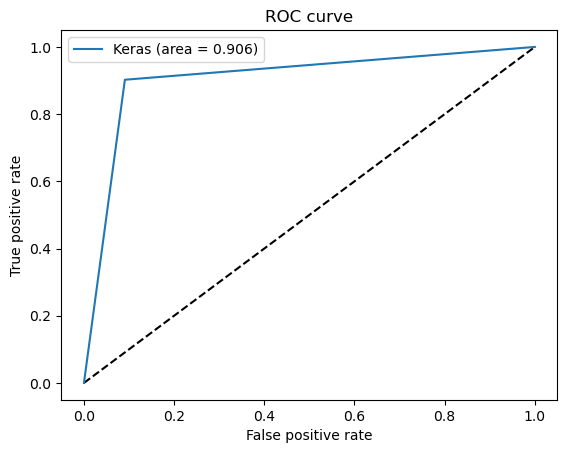

In [94]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [97]:

target_names = ['No cancer', 'cancer']
print(classification_report(submission['true'], submission['predict'], target_names=target_names))

              precision    recall  f1-score   support

   No cancer       0.90      0.91      0.91      2478
      cancer       0.91      0.90      0.91      2478

    accuracy                           0.91      4956
   macro avg       0.91      0.91      0.91      4956
weighted avg       0.91      0.91      0.91      4956



## VGG16

In [98]:
early_stop=EarlyStopping(monitor='val_loss',patience=5)
input_shape = (50,50,3)
vgg16_model = Sequential()

# Block 1
vgg16_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
vgg16_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
vgg16_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 5
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Fully connected layers
vgg16_model.add(Flatten())
vgg16_model.add(Dense(4096, activation='relu'))
vgg16_model.add(Dense(4096, activation='relu'))
vgg16_model.add(Dense(1, activation='sigmoid'))  # Binary classification output

In [99]:
vgg16_model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [100]:
vgg16_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                  

In [101]:
vgg16_history = vgg16_model.fit(train_set,
                     validation_data=val_set,
                    epochs=20, verbose=1)

Epoch 1/20
620/620 [==============================] - 37s 56ms/step - loss: 0.5981 - accuracy: 0.6657 - val_loss: 0.5142 - val_accuracy: 0.7821
Epoch 2/20
620/620 [==============================] - 33s 53ms/step - loss: 0.4781 - accuracy: 0.7814 - val_loss: 0.4581 - val_accuracy: 0.7910
Epoch 3/20
620/620 [==============================] - 33s 53ms/step - loss: 0.4432 - accuracy: 0.7974 - val_loss: 0.4248 - val_accuracy: 0.8037
Epoch 4/20
620/620 [==============================] - 33s 53ms/step - loss: 0.4142 - accuracy: 0.8163 - val_loss: 0.4603 - val_accuracy: 0.7776
Epoch 5/20
620/620 [==============================] - 33s 53ms/step - loss: 0.3895 - accuracy: 0.8275 - val_loss: 0.3692 - val_accuracy: 0.8416
Epoch 6/20
620/620 [==============================] - 33s 53ms/step - loss: 0.3657 - accuracy: 0.8407 - val_loss: 0.3765 - val_accuracy: 0.8333
Epoch 7/20
620/620 [==============================] - 33s 53ms/step - loss: 0.3511 - accuracy: 0.8492 - val_loss: 0.4063 - val_accuracy:

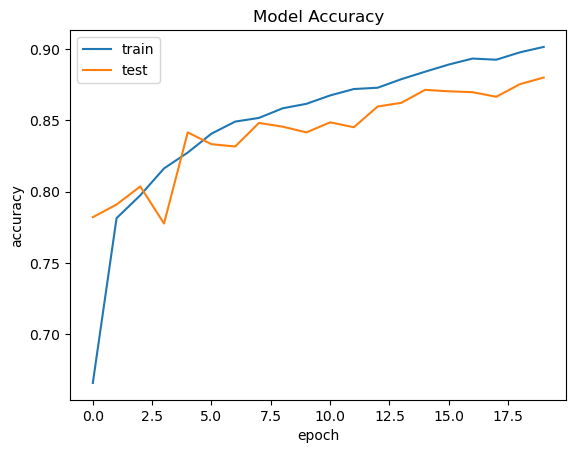

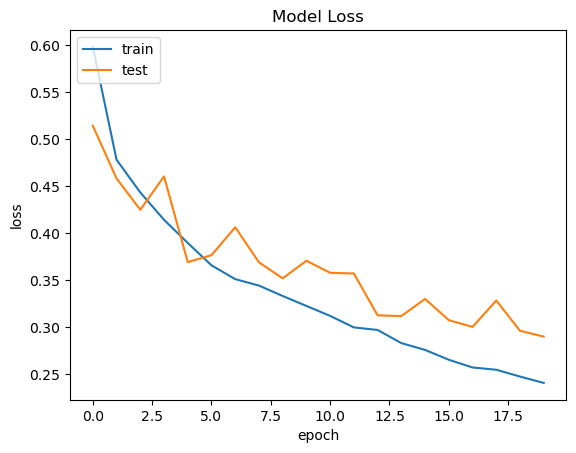

In [103]:
plt.plot(vgg16_history.history['accuracy'])
plt.plot(vgg16_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(vgg16_history.history['loss'])
plt.plot(vgg16_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [104]:
preds_vgg16 = vgg16_model.predict_generator(
    test_generator,
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [106]:
image_ids = [name.split('/')[-1] for name in test_generator.filenames]
predictions = preds_vgg16.flatten()
data = {'id': image_ids, 'cancer':predictions} 
vgg_pred = pd.DataFrame(data)
vgg_pred['predict'] = vgg_pred['cancer'].apply(lambda x: 0 if x < 0.5 else 1)
vgg_pred['true'] = vgg_pred['id'].apply(lambda x: 0 if 'class0' in x else 1)
vgg_pred.head()

,id,cancer,predict,true
0,10274_idx5_x1001_y1251_class0.png,0.222721,0,0
1,10274_idx5_x1001_y2001_class0.png,0.024661,0,0
2,10274_idx5_x1001_y551_class0.png,0.009032,0,0
3,10274_idx5_x1001_y901_class0.png,0.377961,0,0
4,10274_idx5_x101_y1101_class0.png,0.087670,0,0


accuracy == 0.878


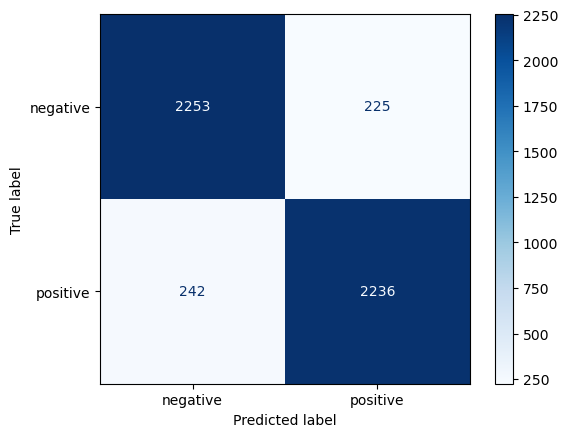

In [107]:
cm = confusion_matrix(submission['true'], submission['predict'])

# Step 4: Display the confusion matrix
labels = test_generator.class_indices.keys()  # Get class labels
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap='Blues')  # plot the confusion matrix
print(f'accuracy == {round(sum(vgg_pred.predict == vgg_pred.true)/len(vgg_pred),3)}')

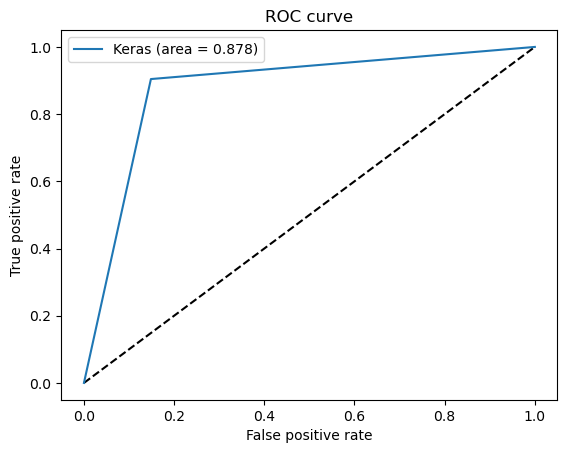

In [108]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(vgg_pred['true'], vgg_pred['predict'])
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [109]:

target_names = ['No cancer', 'cancer']
print(classification_report(vgg_pred['true'], vgg_pred['predict'], target_names=target_names))

              precision    recall  f1-score   support

   No cancer       0.90      0.85      0.87      2478
      cancer       0.86      0.90      0.88      2478

    accuracy                           0.88      4956
   macro avg       0.88      0.88      0.88      4956
weighted avg       0.88      0.88      0.88      4956

